# Brain Tumor Classification with N11 Model

## 1 Load Data
The dataset used in this example is from [Brain MRI Images for Brain Tumor Detection](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection) challenge on Kaggle. 
### 1.1 Create an Annotation File
The brain MRI images are organized as the follows:
```
./brain_tumor_dataset/yes/xxx.jpg
./brain_tumor_dataset/yes/xxy.jpg
./brain_tumor_dataset/yes/xxz.jpg

./brain_tumor_dataset/no/123.jpg
./brain_tumor_dataset/no/456.jpg
./brain_tumor_dataset/no/789.jpg
```
To grab image information and store them in an comma-seperated values (CSV) file:

Visit the data directory, grab all images' paths and corresponding categories.
Save the paths and categories of images in an .csv file

In [2]:
import sys
import os
from glob import glob
import pandas as pd

# Locate train and test directories
root_dir = "./brain_tumor_dataset"  # locate dataset directory from this repo in the whole system
yes_dir = os.path.join(root_dir, "yes")
no_dir = os.path.join(root_dir, "no")
categories = ['yes', 'no']

# Glob training files
yes_files = glob(os.path.join(yes_dir, "*.*"))
no_files = glob(os.path.join(no_dir, "*.*"))
print(f"There are {len(yes_files)} images with tumors, and {len(no_files)} images without tumors in the dataset")
combined_files = yes_files + no_files
labels = ['yes'] * len(yes_files) + ['no'] * len(no_files)
data_dict = {'path': combined_files, 'label': labels}
df = pd.DataFrame(data_dict)
df.to_csv('annotation_data.csv', header=False, index=False)

# # Glob test files
# test_cat_files = glob(os.path.join(test_dir, categories[0], "*.jpg"))
# test_dog_files = glob(os.path.join(test_dir, categories[1], "*.jpg"))
# print(f"There are {len(test_cat_files)} cat images, and {len(test_dog_files)} dog images in the test dataset")
# test_image_files = test_cat_files + test_dog_files
# test_labels = ['cat'] * len(test_cat_files) + ['dog'] * len(test_dog_files)
# test_data_dict = {'path': test_image_files, 'label': test_labels}
# df_test = pd.DataFrame(test_data_dict)
# # print(df_test)
# df_test.to_csv('annotation_test.csv', header=False, index=False)

There are 155 images with tumors, and 98 images without tumors in the dataset


### 1.2 Create a Dataset using PyTorch
1. Inherit the Dataset class to build a customized TumorDetectDataset class.
2. Further create dataloaders to shuffle the data and access the full matrix of the features and the targets.

0 (128, 128) 1
100 (128, 128) 1
200 (128, 128) 0
252 (128, 128) 0


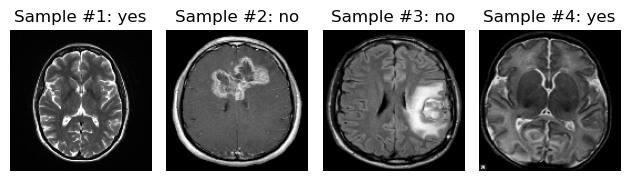

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import cv2
import numpy as np


# Create customized dataset
class TumorDetectDataset(Dataset):
    def __init__(self, annotations_file):
        self.imgs_info = pd.read_csv(annotations_file, header=None)

    def __len__(self):
        return len(self.imgs_info)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_path = self.imgs_info.iloc[idx, 0]
        image_raw = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image_raw, (128, 128))
        category = 1 if self.imgs_info.iloc[idx, 1] == 'yes' else 0
        sample = {'image': image, 'category': category}
        return sample

# Loop training dataset
dataset = TumorDetectDataset(annotations_file='annotation_data.csv')
for i, sample in enumerate(dataset):
    image = sample['image']
    category = sample['category']
    if not i%100:
        print(i, image.shape, category)
print(i, image.shape, category)
    
# Create shuffled data loader 
dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)
samples = next(iter(dataloader))
fig, axs = plt.subplots(1, 4)
for i in range(4):
    image = samples['image'][i]
    category = categories[samples['category'][i]]
    axs[i] = plt.subplot(1, 4, i + 1)
    axs[i].set_title(f'Sample #{i+1}: {category}')
    axs[i].axis('off')
    axs[i].imshow(image, cmap='gray')
    plt.tight_layout()

### 1.3 Data Preprocessing

In [4]:
data_train = next(iter(dataloader))

# Separate features from targets 
raw_features_train = data_train['image'].numpy()
raw_labels_train = data_train['category'].numpy()
print(f"Raw training data shapes: {raw_features_train.shape}, {raw_labels_train.shape}")

# Reshape feature matrix to (M, width*height*3), target vector to (M, 1)
reshaped_features_train = raw_features_train.reshape(raw_features_train.shape[0], -1)
reshaped_labels_train = raw_labels_train.reshape(-1, 1)
# Rescale features within range: 0~1
rescaled_features_train = reshaped_features_train / 255

# Finalize data to be used later
features_train = rescaled_features_train
labels_train = reshaped_labels_train


# Sanity check
print(f"Processed training features shape: {features_train.shape}")
print(f"Processed training labels shape: {labels_train.shape}")


Raw training data shapes: (253, 128, 128), (253,)
Processed training features shape: (253, 16384)
Processed training labels shape: (253, 1)


## 2 One_Hidden Layer, One-Output Neural Network Model


In [5]:
def linear(in_features, weight, bias):
    out_features = in_features @ weight.T + bias
    return out_features

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def forward(in_features, params):
    features_1 = sigmoid(linear(in_features, params['W1'], params['b1']))
    predictions = sigmoid(linear(features_1, params['W2'], params['b2']))
    return predictions, features_1


# Sanity check
params_dummy = {}
params_dummy['W1'] = np.random.normal(size=(10, features_train.shape[1]))
params_dummy['b1'] = np.random.normal(size=(1, 10))
params_dummy['W2'] = np.random.normal(size=(1, 10))
params_dummy['b2'] = np.random.normal()

preds_dummy, X1_dummy = forward(features_train[:4], params_dummy)
print(preds_dummy)
print(X1_dummy.shape)

[[0.10052379]
 [0.10183878]
 [0.62982134]
 [0.03033572]]
(4, 10)


## 3 Binary Cross-Entropy Loss

In [6]:
def bce_loss(predictions, labels):
    """
    Binary Cross Entropy function
        Args:
            predictions: model predicted values, a 2d array with shape (# samples, 1)
            labels: labeled values from data set, a 2d array with shape (# samples, 1)
        Returns:
            loss_value: averaged CE error, a scalar
    """
    ce_error = -labels * np.log(predictions) - (1 - labels) * np.log(1 - predictions)
    return np.mean(ce_error)
    

# Sanity check
print(bce_loss(preds_dummy, labels_train[:4]))

0.7208578559045189


## 4 Gradient Descent Optimization


loss @ 1 iteration: 0.6862779625519353
loss @ 2 iteration: 9.515955543605696
loss @ 3 iteration: nan
loss @ 4 iteration: nan
loss @ 5 iteration: nan


/tmp/ipykernel_105725/3275249942.py:10: RuntimeWarning: divide by zero encountered in log
  ce_error = -labels * np.log(predictions) - (1 - labels) * np.log(1 - predictions)
/tmp/ipykernel_105725/3275249942.py:10: RuntimeWarning: invalid value encountered in multiply
  ce_error = -labels * np.log(predictions) - (1 - labels) * np.log(1 - predictions)


loss @ 6 iteration: nan
loss @ 7 iteration: 11.023560194097493
loss @ 8 iteration: 9.873787551220103
loss @ 9 iteration: 9.212186958213952
loss @ 10 iteration: 8.841852352355863
loss @ 11 iteration: 8.37604685573406
loss @ 12 iteration: 7.909540583552634
loss @ 13 iteration: 6.817644638992692
loss @ 14 iteration: 6.1645292055256
loss @ 15 iteration: 5.961504721073099
loss @ 16 iteration: 5.731191097738726
loss @ 17 iteration: 5.126407720102069
loss @ 18 iteration: 4.6471664321401525
loss @ 19 iteration: 4.603620917083171
loss @ 20 iteration: 4.52038747586599
loss @ 21 iteration: 4.4107231209339925
loss @ 22 iteration: 4.346627411079998
loss @ 23 iteration: 4.200462619610933
loss @ 24 iteration: 3.7673885670939193
loss @ 25 iteration: 3.1733741889182934
loss @ 26 iteration: 2.278733672555791
loss @ 27 iteration: 1.5028755294511582
loss @ 28 iteration: 1.3056909219831996
loss @ 29 iteration: 1.258020232014227
loss @ 30 iteration: 1.1214083875752123
loss @ 31 iteration: 0.7733566745127943

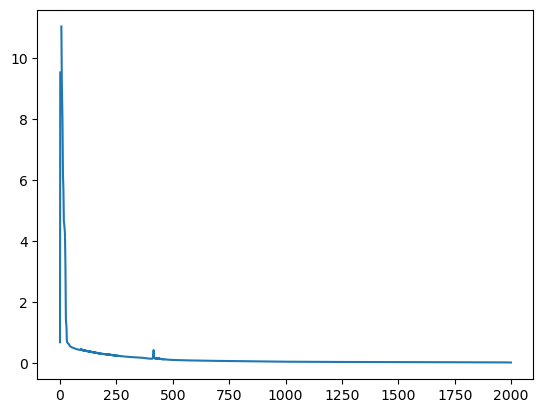

In [15]:
# Define gradient
def grad(in_features, features_1, params, predictions, labels):
    """ Gradient function with sigmoid activation
    Args:
        predictions: model predicted value, a 2d array with shape (# samples, 1)
        labels: labeled value from data set, a 2d array with shape (# samples, 1)
        in_features: feature matrix, a 2d array with shape (# samples, # pixels)
    Returns:
        dw: row vector of BCE loss partial derivatives w.r.t. weights, 2d array with shape (1, # features)
        db: scalar of BCE loss partial derivatives w.r.t. bias
    """
    grads = {}
    grads['dW2'] = (predictions - labels).T @ features_1 / labels.shape[0]
    grads['db2'] = np.mean(predictions - labels)
    grads['dX1'] = (predictions - labels) @ params['W2']
    grads['dW1'] = (grads['dX1'] * features_1 * (1 - features_1)).T @ in_features
    grads['db1'] = np.mean((grads['dX1'] * features_1 * (1 - features_1)), axis=0)

    return grads

# Init parameters
params = {}
params['W1'] = np.random.normal(0, 0.001, size=(128, features_train.shape[1]))
params['b1'] = np.random.normal(size=(1, 128))
params['W2'] = np.random.normal(size=(1, 128))
params['b2'] = np.random.normal()
num_iters = 2000
learning_rate = 0.0003
losses = []
for i in range(num_iters):
    preds_train, X1_train = forward(features_train, params)
    loss = bce_loss(preds_train, labels_train)
    print(f"loss @ {i+1} iteration: {loss}")
    losses.append(loss)
    grads = grad(features_train, X1_train, params, preds_train, labels_train)
    params['W1'] = params['W1'] - learning_rate * grads['dW1']
    params['b1'] = params['b1'] - learning_rate * grads['db1']
    params['W2'] = params['W2'] - learning_rate * grads['dW2']
    params['b2'] = params['b2'] - learning_rate * grads['db2']
# print(f"final parameters: w = {w}, b = {b}")

# Observe loss values
plt.plot(losses)

## Possible Issues:
1. Dataset is skewed with more tumor images (155:98).
2. Dataset scale is small.
3. Not sure if the tumor area is brighter without any pre-processing
4. 